In [6]:
import os
import sqlite3
import pandas as pd
from dotenv import load_dotenv

conn = sqlite3.connect("etl/soccer_analysis.db")

In [3]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
X = [[0, 0, 0], [1, 1, 1], [0.5, 1, 0.5]]
sim_matrix=cosine_similarity(X)

In [4]:
player_names=["mot", "hai", "ba"]

In [7]:
df_similar_scores = pd.DataFrame(sim_matrix, index=player_names, columns=player_names)

In [8]:
df_similar_scores

,mot,hai,ba
mot,0.0,0.000000,0.000000
hai,0.0,1.000000,0.942809
ba,0.0,0.942809,1.000000


In [25]:
query = '''
SELECT *
FROM "2018_2019" AS st17
LEFT JOIN "possession_2018_2019" AS ps17
  ON st17.Player = ps17.Player AND st17.Squad = ps17.Squad AND st17.Nation = ps17.Nation
LEFT JOIN "gca_2018_2019" AS gca17
  ON st17.Player = gca17.Player AND st17.Squad = gca17.Squad AND st17.Nation = gca17.Nation
'''
df = pd.read_sql_query(query, conn)


In [26]:
df = df.loc[:,~df.columns.duplicated()]

In [27]:
df.columns

Index(['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', 'MP',
       'Starts', 'Min', '90s', 'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt',
       'CrdY', 'CrdR', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR',
       'Gls_90', 'Ast_90', 'G+A_90', 'G-PK_90', 'G+A-PK', 'xG_90', 'xAG_90',
       'xG+xAG', 'npxG_90', 'npxG+xAG_90', 'Matches', 'Touches', 'Def Pen',
       'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Att Pen', 'Live', 'Att', 'Succ',
       'Succ%', 'Tkld', 'Tkld%', 'Carries', 'TotDist', 'PrgDist', '1/3', 'CPA',
       'Mis', 'Dis', 'Rec', 'SCA', 'SCA90', 'PassLive', 'PassDead', 'TO', 'Sh',
       'Fld', 'Def', 'GCA', 'GCA90', 'PassLive_90', 'PassDead_90', 'TO_90',
       'Sh_90', 'Fld_90', 'Def_90'],
      dtype='object')

In [32]:
df['Pos'].unique()

array(['DF', 'MF', 'DF,FW', 'GK', 'DF,MF', 'MF,FW', 'FW', 'FW,MF',
       'MF,DF', 'FW,DF'], dtype=object)

In [ ]:
df = df[
    (
        (df['Pos'] =='MF,FW') | 
        )
    ]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = ['npxG+xAG_90','Att 3rd', 'Succ','Succ%', 'Carries', 'PrgDist', 'SCA90', 'GCA90','PassLive_90']
X_values = df[features].values

scaler = StandardScaler()
scaled_values = scaler.fit_transform(X_values)
                
pca_converter = PCA(n_components=2)
principal_components = pca_converter.fit_transform(scaled_values)
pca_df = pd.DataFrame(principal_components, columns=['PCA1', 'PCA2'])

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [19]:
pca_df = pca_df[
    (
        (pca_df['PCA1'] >= df['PCA1'].max() * 0.65) | (pca_df['PCA2'] >= pca_df['PCA2'].max() * 0.65)
    )
]

KeyError: 'PCA1'

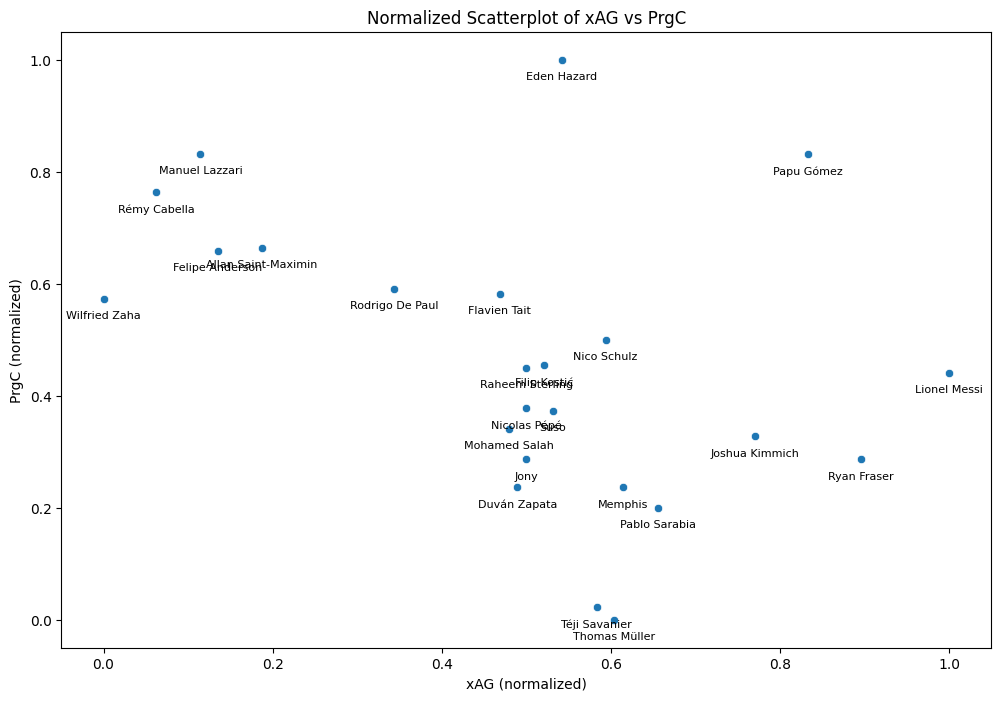

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Min-Max normalization
df['xAG_norm'] = (df['xAG'] - df['xAG'].min()) / (df['xAG'].max() - df['xAG'].min())
df['PrgC_norm'] = (df['PrgC'] - df['PrgC'].min()) / (df['PrgC'].max() - df['PrgC'].min())

plt.figure(figsize=(12, 8))
ax = sns.scatterplot(data=df, x='xAG_norm', y='PrgC_norm')

for _, row in df.iterrows():
    ax.text(x=row['xAG_norm'], y=row['PrgC_norm'] - 0.03, s=row['Player'], fontsize=8, ha='center', va='center')

ax.set_xlabel('xAG (normalized)')
ax.set_ylabel('PrgC (normalized)')
plt.title('Normalized Scatterplot of xAG vs PrgC')
plt.show()